## Import Dataset and EDA

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
import seaborn as sns
from sklearn import svm
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import Input
from keras.layers import Dense
from tensorflow.keras import layers

from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

In [3]:
df = pd.read_csv('/content/Dataset for People for their Blood Glucose Level with their Superficial body feature readings.csv')

In [4]:
df.head()

,Age,Blood Glucose Level(BGL),Diastolic Blood Pressure,Systolic Blood Pressure,Heart Rate,Body Temperature,SPO2,Sweating (Y/N),Shivering (Y/N),Diabetic/NonDiabetic (D/N)
0,9,79,73,118,98,98.300707,99,0,0,N
1,9,80,73,119,102,98.300707,94,1,0,N
2,9,70,76,110,81,98.300707,98,1,0,N
3,9,70,78,115,96,98.300707,96,1,0,N
4,66,100,96,144,92,97.807052,98,0,0,N


In [5]:
df = df.sample(frac=1, random_state=42)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16969 entries, 6109 to 15795
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         16969 non-null  int64  
 1   Blood Glucose Level(BGL)    16969 non-null  int64  
 2   Diastolic Blood Pressure    16969 non-null  int64  
 3   Systolic Blood Pressure     16969 non-null  int64  
 4   Heart Rate                  16969 non-null  int64  
 5   Body Temperature            16969 non-null  float64
 6   SPO2                        16969 non-null  int64  
 7   Sweating  (Y/N)             16969 non-null  int64  
 8   Shivering (Y/N)             16969 non-null  int64  
 9   Diabetic/NonDiabetic (D/N)  16969 non-null  object 
dtypes: float64(1), int64(8), object(1)
memory usage: 1.4+ MB


In [7]:
df['Diabetic/NonDiabetic (D/N)'] = df['Diabetic/NonDiabetic (D/N)'].replace({'D': 1, 'N': 0})

In [8]:
#we check the value count
df['Diabetic/NonDiabetic (D/N)'].value_counts()

1    16641
0      328
Name: Diabetic/NonDiabetic (D/N), dtype: int64

In [9]:
df['Diabetic/NonDiabetic (D/N)'].value_counts(normalize = True)

1    0.980671
0    0.019329
Name: Diabetic/NonDiabetic (D/N), dtype: float64

Dataset seems to be unbalanced, here we have to choices:

* Oversampling: This is usually done by creating synthetic samples from the minority class in order to achieve balanced dataset.

* Undersampling: Done by removing samples from the majority class to have the same number of records for both classes.

It seems difficult to undersample here because we will lose much information as the ratio of both labels is ~98% for the Diabetic class.

Before doing oversampling, we check the scattering of both labels within the original dataset w.r.t. different features

<Axes: xlabel='Blood Glucose Level(BGL)', ylabel='Heart Rate'>

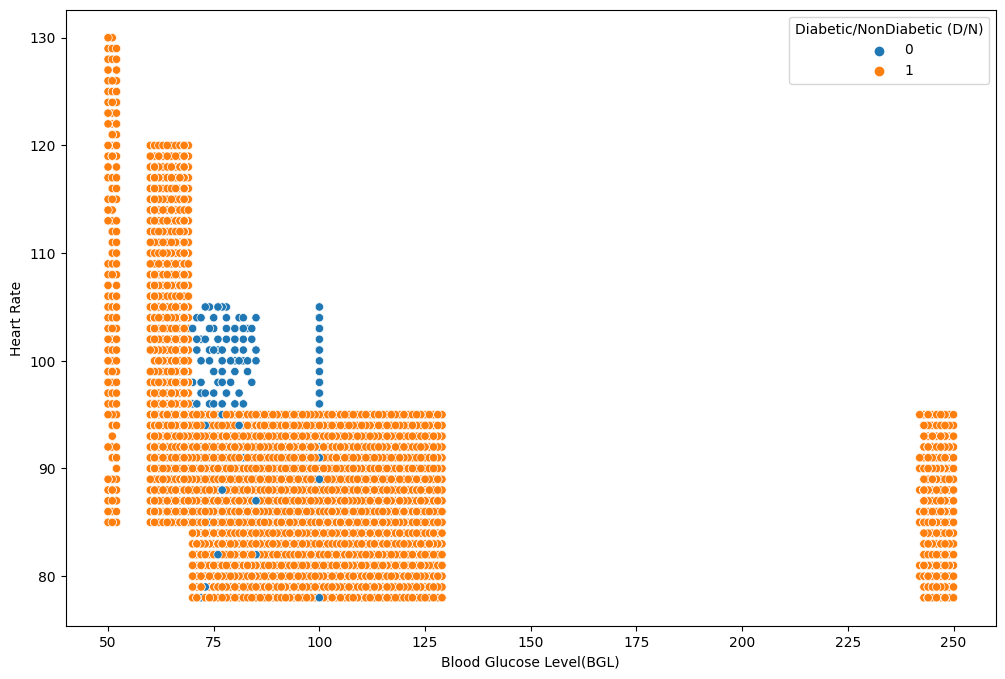

In [10]:
#w.r.t. Heart Rate and BGL
plt.figure(figsize=(12, 8))
sns.scatterplot(x = 'Blood Glucose Level(BGL)', y = 'Heart Rate', hue = 'Diabetic/NonDiabetic (D/N)', data = df)

<Axes: xlabel='Age', ylabel='Blood Glucose Level(BGL)'>

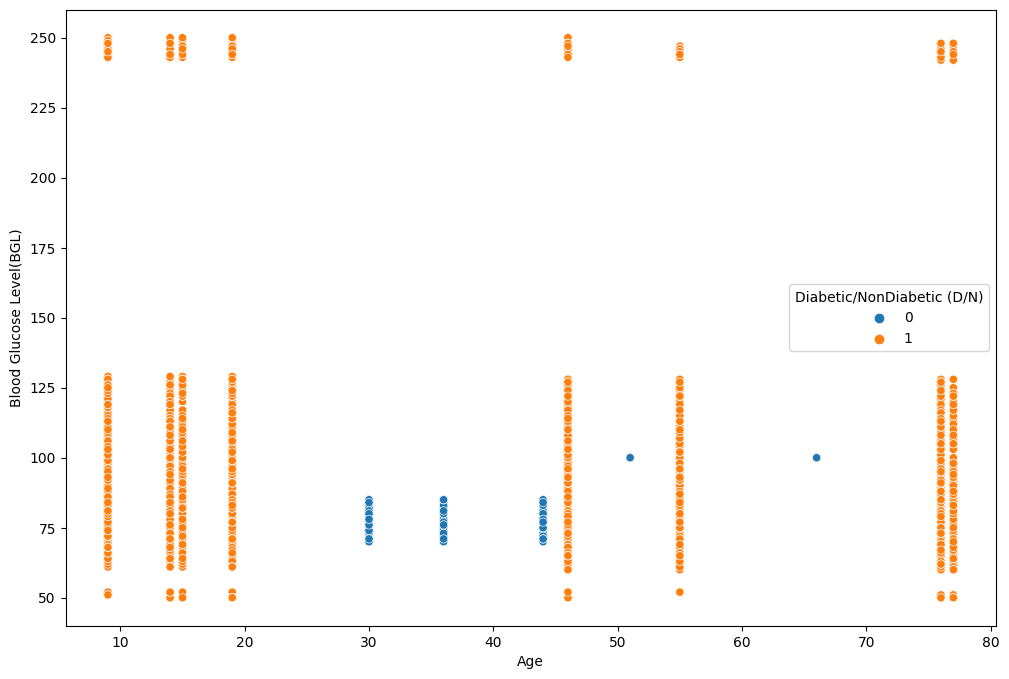

In [11]:
#w.r.t. Age and BGL
plt.figure(figsize=(12, 8))
sns.scatterplot(x = 'Age', y = 'Blood Glucose Level(BGL)', hue = 'Diabetic/NonDiabetic (D/N)', data = df)

Let's start trying to get more insights about BGL.

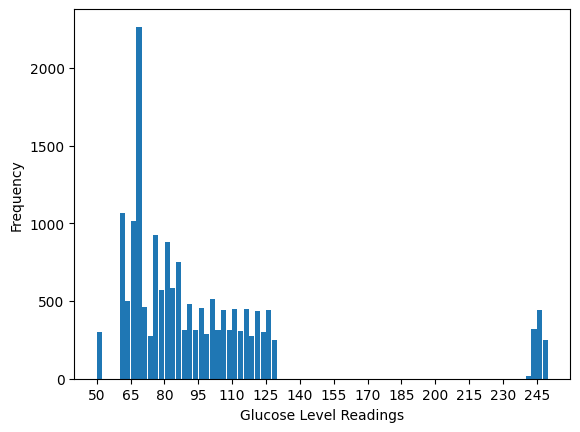

In [12]:
# Plot the histogram
df['Blood Glucose Level(BGL)'].plot.hist(bins=80, rwidth=0.9)

# Set x-axis label
plt.xlabel('Glucose Level Readings')

# Set x-axis ticks
plt.xticks(range(df['Blood Glucose Level(BGL)'].min(), df['Blood Glucose Level(BGL)'].max() + 1, 15))

# Display the histogram
plt.show()

It seems that the peak of the readings is in between 65 and 80, which is considered as the normal BGL for an individual.

Now we study correlation between features and the target (BGL)..

Note that Spearman catches non-linearity which is why it's mostly preferred.


In [13]:
correlations = df.corr(method='spearman')

In [14]:
bgl_correlations = correlations['Blood Glucose Level(BGL)'].sort_values(ascending=False)
print(bgl_correlations.to_string())

Blood Glucose Level(BGL)      1.000000
Diastolic Blood Pressure      0.512940
Systolic Blood Pressure       0.256024
SPO2                          0.235462
Body Temperature              0.210674
Diabetic/NonDiabetic (D/N)    0.019332
Age                          -0.013991
Sweating  (Y/N)              -0.341332
Shivering (Y/N)              -0.439731
Heart Rate                   -0.519921


It seems that the mostly correlated features to the BGL are Diastolic BP, HR, Shivering and Sweating.

But remember that Correlation doesn't imply Causation, we check scatter plots for the BGL and the DSP/HR.

<Axes: xlabel='Heart Rate', ylabel='Blood Glucose Level(BGL)'>

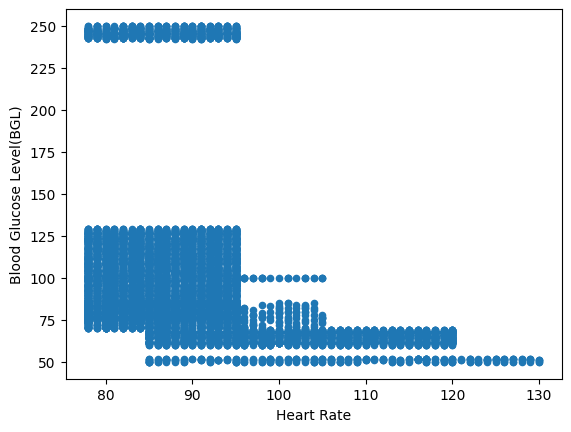

In [15]:
#check scatter plot
df.plot(kind='scatter', x='Heart Rate', y='Blood Glucose Level(BGL)')

<Axes: xlabel='Diastolic Blood Pressure', ylabel='Blood Glucose Level(BGL)'>

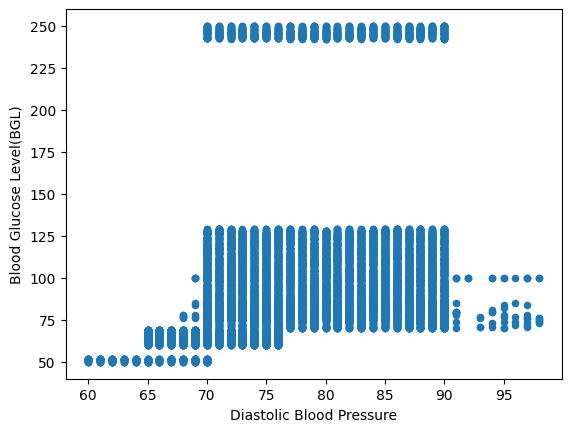

In [16]:
#check scatter plot
df.plot(kind='scatter', x='Diastolic Blood Pressure', y='Blood Glucose Level(BGL)')

It seems that whenever DBP is high then the BGL is also high and when DBP is low then BGL is also low. Moreover, the opposite in HR where if HR is low then BGL is mostly high and vice versia.

We draw a box plot for Age.

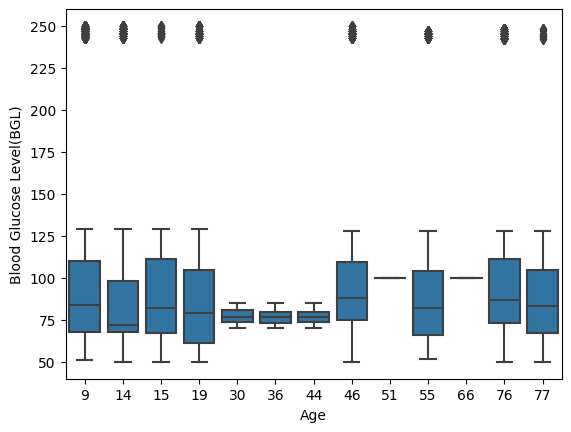

In [17]:
sns.boxplot(data=df, x='Age', y='Blood Glucose Level(BGL)', color=sb.color_palette()[0]);

For ages 30,36,44 the maximum and minimum BGL was in between 50 and 100, which was obvious in the scatter plot with Age and BGL above.

## ML

We compare between two approaches:

* NN

* XGBoost

However, dataset seems pretty unbalanced to make its results reliable for our classification problem. Hence, we use Oversampling.

In [18]:
df_without_labels = df.drop(columns={'Diabetic/NonDiabetic (D/N)'})

In [19]:
diabetic_labels = df['Diabetic/NonDiabetic (D/N)'].values

In [20]:
X_train, X_rem, y_train, y_rem = train_test_split(df_without_labels, diabetic_labels, test_size=0.3, random_state=56)
X_val,X_test,y_val,y_test = train_test_split(X_rem,y_rem,test_size=0.5,random_state=41)

In [21]:
smote = SMOTE(sampling_strategy='auto')
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [22]:
X_train_smote.shape

(23292, 9)

We create a dataframe for the `X_train_smote`

In [24]:
df_smote = pd.concat([pd.DataFrame(X_train_smote), pd.DataFrame(y_train_smote)], axis=1)

In [25]:
df_smote = df_smote.rename(columns={0:'Diabetic/NonDiabetic (D/N)'})

In [27]:
#we check the value count again
df_smote['Diabetic/NonDiabetic (D/N)'].value_counts(normalize=True)

1    0.5
0    0.5
Name: Diabetic/NonDiabetic (D/N), dtype: float64

We scatter plot `df_smote` and see the difference

<Axes: xlabel='Blood Glucose Level(BGL)', ylabel='Heart Rate'>

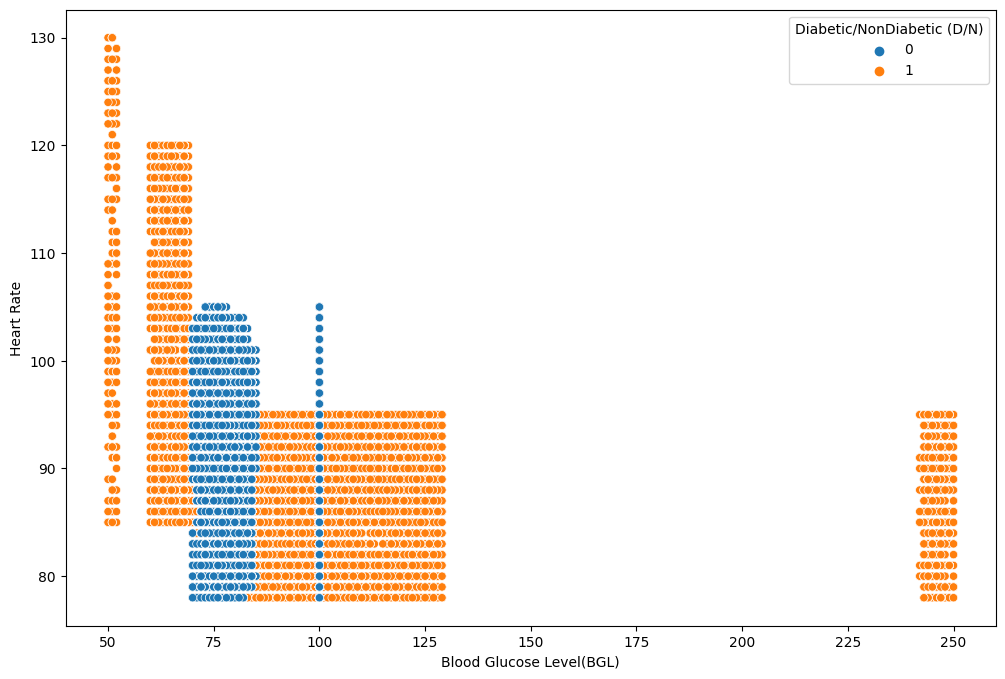

In [28]:
#w.r.t. Heart Rate and BGL
plt.figure(figsize=(12, 8))
sns.scatterplot(x = 'Blood Glucose Level(BGL)', y = 'Heart Rate', hue = 'Diabetic/NonDiabetic (D/N)', data = df_smote)

Compare between this and the results of Random Oversampling..

In [29]:
#XGB Classifier
num_classes = 2  #set the number of classes in your dataset

xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, seed=123)
eval_set = [(X_val,y_val)]

#fit the classifier to the training set
xg_cl.fit(X_train_smote, y_train_smote, eval_metric=["error"], eval_set=eval_set, verbose=True)
results = xg_cl.evals_result()

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.10177
[1]	validation_0-error:0.10177
[2]	validation_0-error:0.10177
[3]	validation_0-error:0.10177
[4]	validation_0-error:0.07426
[5]	validation_0-error:0.06248
[6]	validation_0-error:0.05776
[7]	validation_0-error:0.02161
[8]	validation_0-error:0.02122
[9]	validation_0-error:0.02083
[10]	validation_0-error:0.01807
[11]	validation_0-error:0.01768
[12]	validation_0-error:0.01297
[13]	validation_0-error:0.01297
[14]	validation_0-error:0.01297
[15]	validation_0-error:0.00982
[16]	validation_0-error:0.00982
[17]	validation_0-error:0.00982
[18]	validation_0-error:0.00668
[19]	validation_0-error:0.00668
[20]	validation_0-error:0.00589
[21]	validation_0-error:0.00589
[22]	validation_0-error:0.00550
[23]	validation_0-error:0.00550
[24]	validation_0-error:0.00511
[25]	validation_0-error:0.00472
[26]	validation_0-error:0.00472
[27]	validation_0-error:0.00472
[28]	validation_0-error:0.00472
[29]	validation_0-error:0.00472
[30]	validation_0-error:0.00472
[31]	validation_0-

In [33]:
#predict the labels of the test set: preds
predictions = xg_cl.predict(X_test)
#get accuracy
accuracy = accuracy_score(y_test,predictions)
print("accuracy: %f" % (accuracy*100))

#get precision
precision = precision_score(y_test, predictions)

print("precision: %f" % (precision*100))

accuracy: 99.764336
precision: 99.919775


We use NN afterwards..

In [34]:
model = tf.keras.Sequential([
    layers.Input(shape=(9,)),
    layers.Dense(128, activation='tanh'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1280      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 3

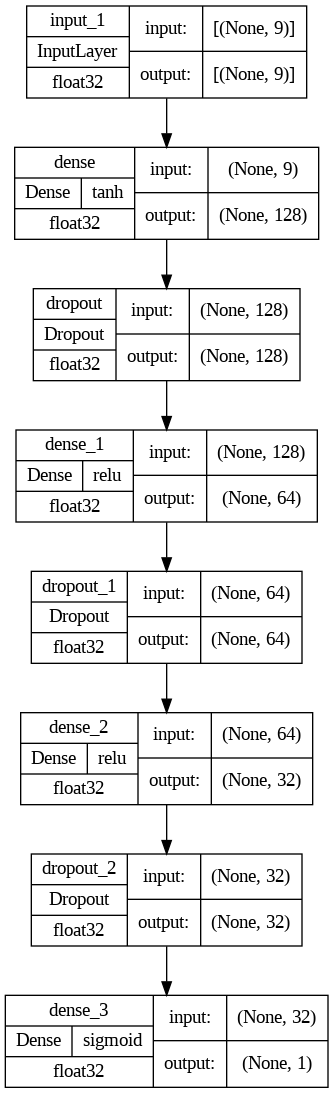

In [39]:
tf.keras.utils.plot_model(model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True
)

Note that we splitted the dataset to be 70-15-15 distribution of train,val and test datasets.

We oversampled the training dataset only and will evaluate the performance of the model based on val/test splits.

In [40]:
model.fit(X_train_smote, y_train_smote,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=64,
                    verbose=1)

Epoch 1/10
364/364 [==============================] - 4s 5ms/step - loss: 0.6647 - accuracy: 0.6032 - val_loss: 0.5001 - val_accuracy: 0.6432
Epoch 2/10
364/364 [==============================] - 1s 4ms/step - loss: 0.5159 - accuracy: 0.7367 - val_loss: 0.3949 - val_accuracy: 0.7006
Epoch 3/10
364/364 [==============================] - 2s 5ms/step - loss: 0.4502 - accuracy: 0.7834 - val_loss: 0.3579 - val_accuracy: 0.8601
Epoch 4/10
364/364 [==============================] - 1s 4ms/step - loss: 0.4026 - accuracy: 0.8104 - val_loss: 0.3311 - val_accuracy: 0.8330
Epoch 5/10
364/364 [==============================] - 1s 3ms/step - loss: 0.3717 - accuracy: 0.8311 - val_loss: 0.2991 - val_accuracy: 0.8417
Epoch 6/10
364/364 [==============================] - 1s 3ms/step - loss: 0.3516 - accuracy: 0.8387 - val_loss: 0.2995 - val_accuracy: 0.8255
Epoch 7/10
364/364 [==============================] - 1s 3ms/step - loss: 0.3276 - accuracy: 0.8542 - val_loss: 0.2764 - val_accuracy: 0.8255
Epoch 

In [41]:
model.evaluate(X_test,y_test)

80/80 [==============================] - 0s 2ms/step - loss: 0.2006 - accuracy: 0.8633


[0.20062921941280365, 0.8633149862289429]

The higher performance of XGBoost is logical given that it is more robust to outliers than Neural Networks. Moreover, XGBoost has in-built regularization parameters to prevent overfitting. This includes both L1 and L2
regularization to avoid overfitting, overcoming complex data distribution.

The NN was deployed in the mobile application

In [42]:
model.save('NN_IEEE_Dataset.h5')